In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from os.path import exists

from tqdm.notebook import tqdm
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit
# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

#вычисляем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LassoCV, RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from sklearn.metrics import mean_absolute_error,r2_score

In [2]:
#Структуры данных этого проекта Автор, Публикация, Аннотация публикации
from data_types import AuthorsDB
from data_types import PublicationsDB
from data_types import AbstractsDB

## Загрузка данных
Обработка и создание, которых происходила в основном в файлах: 
- iterate_through_authors.ipynb
- parsing_page.py
- data_types.py

In [3]:
audb = AuthorsDB()
audb.load()
pubdb = PublicationsDB()
pubdb.load()
absdb = AbstractsDB()
absdb.load()

filename = "../data/mathnet_iam_authors_dict.pkl"
with open(filename,'rb') as inp:
    authors_dict = pickle.load(inp)

# EDA

## 1.1 Используемые базы данных

### 1.1.1 Структуры отвечающие за Авторов
 - authors_dict - Имя и индекс mathnet_id
 - audb - Автор и его статьи

In [4]:
for ind, person in authors_dict.items():
    if ind<4:
        print(person)

{'name': 'Абалакин Илья Владимирович', 'mn_id': '29400'}
{'name': 'Авдуевский Всеволод Сергеевич', 'mn_id': '25875'}
{'name': 'Агапов Владимир Михайлович', 'mn_id': '79709'}


In [5]:
mn_id = "29400"
for ind, item in enumerate(audb.db['29400']):
    if ind < 3:
        print(ind)
        print(item)
        print(audb.db['29400'][item])    

0
mm4353
{'year': '2022', 'nrf': 2}
1
mm4312
{'year': '2021', 'nrf': 2}
2
zvmmf11279
{'year': '2021', 'nrf': 1}


Number of authors

In [6]:
print(f"Number of received authors {len(audb.db.keys())}")
print(f"Number of authors in list  {len(authors_dict.keys())}")
print(f"Percent of received authors = {round(100*(len(audb.db.keys())/len(authors_dict.keys())),1)}%")

Number of received authors 871
Number of authors in list  871
Percent of received authors = 100.0%


### 1.1.2 Датафрейм с основной информацией о публикации

In [7]:
pub = pd.DataFrame.from_dict(pubdb.db,orient='index')

In [8]:
pub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7597 entries, vyurv213 to vmumm4420
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  7597 non-null   object
 1   doi        1624 non-null   object
 2   udk        3119 non-null   object
 3   send       2844 non-null   object
 4   type       5398 non-null   object
 5   reference  7597 non-null   object
 6   by         7081 non-null   object
 7   paper      7081 non-null   object
 8   jour       7025 non-null   object
 9   yr         7081 non-null   object
 10  vol        4534 non-null   object
 11  issue      4605 non-null   object
 12  pages      4707 non-null   object
dtypes: object(13)
memory usage: 830.9+ KB


In [9]:
pub.head()

,author_id,doi,udk,send,type,reference,by,paper,jour,yr,vol,issue,pages
vyurv213,"[113970, 148811, 22428]","<a class=""SLink"" href=""https://doi.org/10.1452...",004.052.3,20.11.2018,Статья,,"А.~А.~Бондаренко, П.~А.~Ляхов, М.~В.~Якобовский",Координированное сохранение с журналированием ...,Вестн. ЮУрГУ. Сер. Выч. матем. информ.,2019,8,2,76--91
vyurv1,"[113970, 22428]","<a class=""SLink"" href=""https://doi.org/10.1452...",004.052.3,13.04.2015,Статья,,"А.~А.~Бондаренко, М.~В.~Якобовский",Моделирование отказов в высокопроизводительных...,Вестн. ЮУрГУ. Сер. Выч. матем. информ.,2015,4,3,5--12
vyurv46,"[113970, 22428]",None,004.052.3,05.08.2014,Статья,,"А.~А.~Бондаренко, М.~В.~Якобовский",Обеспечение отказоустойчивости высокопроизводи...,Вестн. ЮУрГУ. Сер. Выч. матем. информ.,2014,3,3,20--36
ipmp2988,"[25339, 26426, 31779, 26427]",:https://doi.org/10.20948/prepr-2021-71,None,None,Препринт,"С. В. Поляков, М. А. Трапезникова, А. Г. Чурба...","С.~В.~Поляков, М.~А.~Трапезникова, А.~Г.~Чурба...",Расчет несжимаемых течений в системе &lt;&lt;п...,Препринты ИПМ им.~М.~В.~Келдыша,2021,None,None,None
ipmp2939,"[101245, 25339, 163334]",:https://doi.org/10.20948/prepr-2021-21,None,None,Препринт,"Б. Г. Фрейнкман, С. В. Поляков, И. О. Толстов,...","Б.~Г.~Фрейнкман, С.~В.~Поляков, И.~О.~Толстов",Расчет основного состояния электрона в неоднор...,Препринты ИПМ им.~М.~В.~Келдыша,2021,None,None,None


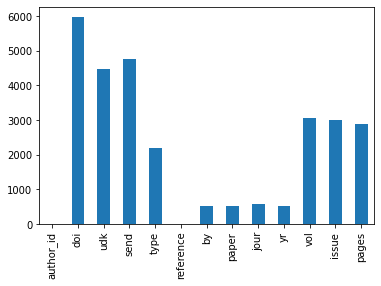

In [10]:
pub.isnull().sum().plot(kind='bar');

### 1.1.3 Датафрейм с аннотациями публикаций 

In [11]:
absdb.db.head()

,abstract,keywords
mn_link,,
vyurv213,Увеличивающийся рост числа компонент суперкомп...,"расширение ULFM, контрольные точки, координиро..."
vyurv1,Рассматривается проблема выполнения длительных...,"параллельные вычисления, отказоустойчивость, к..."
vyurv46,"Рассматриваются вопросы, связанные с проведени...","параллельные вычисления, отказоустойчивость, к..."
ipmp2988,В данной работе рассмотрена модель для сопряже...,"модель Бринкмана, уравнения Навье-Стокса, своб..."
ipmp2939,Данное исследование связано с разработкой мате...,"математическое моделирование, решетка графена,..."


In [12]:
absdb.db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7597 entries, vyurv213 to vmumm4420
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  5609 non-null   object
 1   keywords  2525 non-null   object
dtypes: object(2)
memory usage: 178.1+ KB


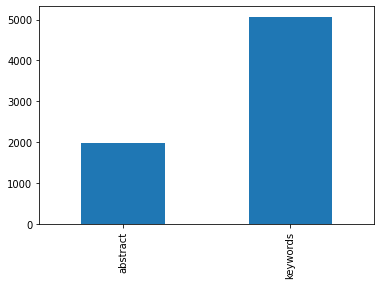

In [13]:
absdb.db.isnull().sum().plot(kind='bar');

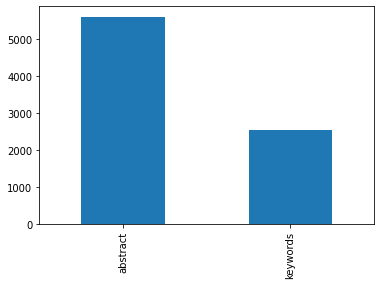

In [14]:
absdb.db.notnull().sum().plot(kind='bar');

## 1.2 Публикации и артефакты в них

In [15]:
print(f"Number of received papers is       {len(absdb.db.index)}")
print(f"Number of papers without abstracts {(absdb.db['abstract'].isnull()).sum()}")
print(f"Number of papers without keywords  {(absdb.db['keywords'].isnull()).sum()}")

Number of received papers is       7597
Number of papers without abstracts 1988
Number of papers without keywords  5072


Просмотрим стать на артефакты 

In [16]:
w_year = 0
new_count = 0
old_count = 0
breaking_year = 2008
links_to_check = ['http://mi.mathnet.ru/'+mn_link for mn_link in absdb.db.index[absdb.db['abstract'].isnull()]]
for link, slink in zip(links_to_check, absdb.db.index[absdb.db['abstract'].isnull()]):
    year = pub.loc[slink,'yr']    
    if year is None:
        # print(f"year = {year}, name = {pub.loc[slink,'paper']}, link = {link} ")
        w_year+=1
    else:
        if int(year)>breaking_year:    
            new_count +=1
            if new_count <6:
                print(f"year = {year},  link = {link}, name = {pub.loc[slink,'paper']}, ")
        else:
            old_count +=1
print(f"Number of papers without abstracts without 'year' field is {w_year}")
print(f"Count of NEW papers without abstracts {new_count}")
print(f"Count of OLD papers without abstracts {old_count}")


year = 2021,  link = http://mi.mathnet.ru/mm4267, name = Памяти Николая Николаевича Калиткина, 
year = 2018,  link = http://mi.mathnet.ru/mm3935, name = Памяти Александра Сергеевича Холодова, 
year = 2017,  link = http://mi.mathnet.ru/crm91, name = Памяти Александра Сергеевича Холодова (11.10.1941 -- 05.11.2017), 
year = 2017,  link = http://mi.mathnet.ru/svmo668, name = Юрий Николаевич Дерюгин~--- к семидесятилетию со дня рождения, 
year = 2016,  link = http://mi.mathnet.ru/mm3685, name = Памяти О.\,М.~Белоцерковского, 
Number of papers without abstracts without 'year' field is 414
Count of NEW papers without abstracts 127
Count of OLD papers without abstracts 1447


# 2 Построим модель

## 2.1 Публикации и их года
Год будет выступать в качестве target для нашей модели

In [17]:
abstracts = absdb.db[absdb.db['abstract'].notna()]

Из-за формата хранения данных, а также пропусках при web-scraping, года иногда отсутствуют в одной или другой структуре, поэтому чтобы получить год для аннотации, надо специальным образом обходить обе структуры, где может быть год аннотации . 

In [18]:
def get_year_of_pubid(list_pubsid):
    struct = {}
    for pibid in list_pubsid:
        if pub.loc[pibid,'yr'] is not None:
            struct[pibid]=int(pub.loc[pibid,'yr'])
        else:          
            authors_list = pub.loc[pibid,'author_id']
            for author in authors_list:
                if author not in audb.db:
                    continue         
                if pibid not in audb.db[author]:
                    print(f"wtf?? pibid= {pibid}, pub.loc[pibid] =  {pub.loc[pibid]}")
                    continue
                struct[pibid]=  int(audb.db[author][pibid]['year'])
                break    
    return struct 

In [19]:
y_list = get_year_of_pubid(abstracts.index)
y_df = pd.DataFrame.from_dict(y_list,orient="index",columns=['year'])

Удалим стаьти из рассмотрения, если в этом году, было меньше 10 статей

In [20]:
print((y_df.value_counts()<10).sum())

14


<AxesSubplot:xlabel='year'>

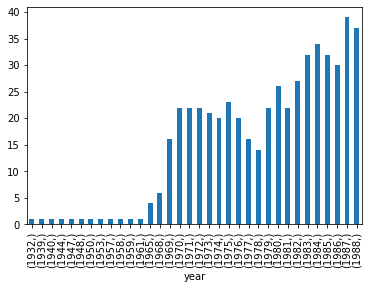

In [21]:
y_df[y_df['year']<1989].value_counts(sort=False).plot.bar()

In [22]:
(y_df['year']==1969).sum()

16

In [23]:
y_df.drop(y_df[y_df['year']<1969].index, inplace=True)

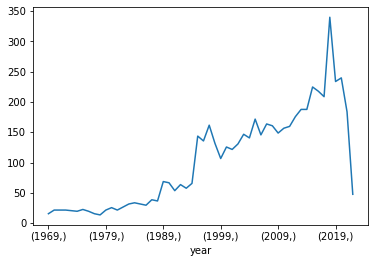

In [24]:
y_df.value_counts(sort=False).plot();

In [25]:
y_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5582 entries, vyurv213 to da31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    5582 non-null   int64
dtypes: int64(1)
memory usage: 87.2+ KB


In [26]:
y_df.describe()

,year
count,5582.000000
mean,2005.861519
std,11.976459
min,1969.000000
25%,1998.000000
50%,2008.000000
75%,2016.000000
max,2022.000000


Дублирующихся индексов статей нет

In [27]:
y_df.index.duplicated(keep=False).sum()

0

Проверяем, что индексы совпадают

In [28]:
abstracts.index.equals(y_df.index)

False

Далее будем рассматривать только те аннотации, для которых есть год

In [29]:
abstracts = abstracts.loc[y_df.index].copy()

In [30]:
abstracts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5582 entries, vyurv213 to da31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  5582 non-null   object
 1   keywords  2525 non-null   object
dtypes: object(2)
memory usage: 130.8+ KB


In [31]:
abstracts["abstract"].notna().sum()

5582

## 2.2 Itf-idf матрицы уни/би/три-грам 

In [32]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# примеры стоп-слов
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [33]:
# знаки препинания
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
word_tokenizer = nltk.WordPunctTokenizer()

In [35]:
def process_abstractsdb(data):
    texts = []    
    
    # поочередно проходим по всем новостям в списке
    for index,row in data.iterrows():
        # print(row['abstract'])        
        # print(type(row['abstract']))
        text = row['abstract']
        if (row['keywords'] is not None):
            # print(text)
            # print(row['keywords'])
            # print(type(row['keywords']))
            text += row['keywords']                   
        text_lower = text.lower() # приводим все слова к нижнему регистру
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем екст на слова                
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and not word.isnumeric())]
                      
        texts.append(tokens) # добавляем в предобработанный список
    
    return texts

In [36]:
texts = process_abstractsdb(abstracts)
# инициализируем лемматизатор
morph = pymorphy2.MorphAnalyzer()

In [37]:
for aword in texts[2]:
    aword_norm = morph.parse(aword)[0].normal_form
    print("Исходное слово: %s \tЛемматизированное: %s" % (aword, aword_norm))

Исходное слово: рассматриваются 	Лемматизированное: рассматриваться
Исходное слово: вопросы 	Лемматизированное: вопрос
Исходное слово: связанные 	Лемматизированное: связанный
Исходное слово: проведением 	Лемматизированное: проведение
Исходное слово: расчетов 	Лемматизированное: расчёт
Исходное слово: распределенных 	Лемматизированное: распределённый
Исходное слово: вычислительных 	Лемматизированное: вычислительный
Исходное слово: системах 	Лемматизированное: система
Исходное слово: компоненты 	Лемматизированное: компонент
Исходное слово: которых 	Лемматизированное: который
Исходное слово: подвержены 	Лемматизированное: подверженный
Исходное слово: отказам 	Лемматизированное: отказ
Исходное слово: работе 	Лемматизированное: работа
Исходное слово: приводятся 	Лемматизированное: приводиться
Исходное слово: определения 	Лемматизированное: определение
Исходное слово: системы 	Лемматизированное: система
Исходное слово: сбоя 	Лемматизированное: сбой
Исходное слово: ошибки 	Лемматизированное: 

In [38]:
# применяем лемматизацию ко всем текстам
print(range(len(texts)))

file_lemmatized_text = '../data/lemmatized_text.pkl'
if exists(file_lemmatized_text):    
    with open(file_lemmatized_text,'rb') as inp:
        texts = pickle.load(inp)
else:
    for i in tqdm(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
        text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
        texts[i] = ' '.join(text_lemmatized)
    with open(file_lemmatized_text,'wb') as outp:
        pickle.dump(texts,outp,pickle.HIGHEST_PROTOCOL)

range(0, 5582)


In [107]:
vectorizer = TfidfVectorizer(min_df=0.01, max_df = 0.3,   max_features=300, analyzer='word',token_pattern=r'\w{2,}', ngram_range=(1, 3), use_idf=1, smooth_idf=1,sublinear_tf=1) 
vectorizer.fit(texts)

TfidfVectorizer(max_df=0.3, max_features=300, min_df=0.01, ngram_range=(1, 3),
                smooth_idf=1, sublinear_tf=1, token_pattern='\\w{2,}',
                use_idf=1)

In [108]:
print('Number of features in vectorizer:', len(vectorizer.get_feature_names_out()))
for ind,item in enumerate(vectorizer.get_feature_names_out()):
    if ind<10:
        print(ind, item)

Number of features in vectorizer: 300
0 of
1 алгоритм
2 анализ
3 аналитический
4 аппарат
5 аппроксимация
6 библа
7 больший
8 вариант
9 величина


In [109]:
tf_idf_matrix = vectorizer.fit_transform(texts)
print(tf_idf_matrix.shape)

(5582, 300)


In [110]:
X = tf_idf_matrix.toarray()
y = y_df.to_numpy()

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3076)

In [112]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3907, 300)
(1675, 300)
(3907, 1)
(1675, 1)


In [113]:
def get_baseline(y):
    return np.ones(y_test.shape)*y_test.mean()

In [114]:
output = []

In [115]:
def plotCoefficients(feature_importances, words):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(feature_importances, words)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.iloc[:30].coef.plot(kind='bar')
    plt.grid(True, axis='y')
    # plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [116]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
errors={'Linear Regression':{        
        "Mean absolute error":mean_absolute_error(y_test,y_pred_lr),
        "Mean squared error":mean_squared_error(y_test,y_pred_lr,squared=True),
        "Root mean squared error":mean_squared_error(y_test,y_pred_lr,squared=False)
        }}
output.append(errors)

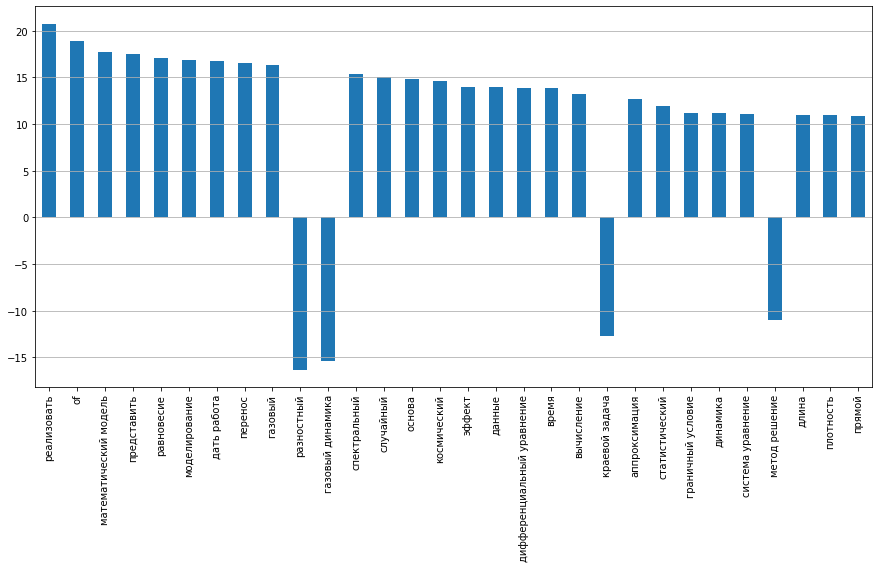

In [117]:
plotCoefficients(lr.coef_.T,vectorizer.get_feature_names_out())

In [118]:
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
errors={'Ridge':{        
        "Mean absolute error":mean_absolute_error(y_test,y_pred_ridge),
        "Mean squared error":mean_squared_error(y_test,y_pred_ridge,squared=True),
        "Root mean squared error":mean_squared_error(y_test,y_pred_ridge,squared=False)        
        }}
output.append(errors)

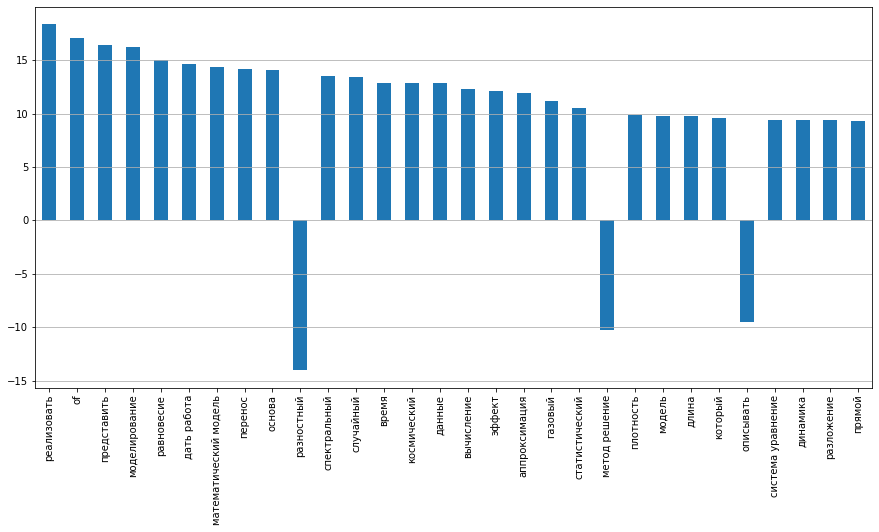

In [119]:
plotCoefficients(ridge.coef_.T,vectorizer.get_feature_names_out())

In [120]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train.ravel())
y_pred_rf = rf.predict(X_test)
errors={'Random Forest':{        
        "Mean absolute error":mean_absolute_error(y_test,y_pred_rf),
        "Mean squared error":mean_squared_error(y_test,y_pred_rf,squared=True),
        "Root mean squared error":mean_squared_error(y_test,y_pred_rf,squared=False)
        }}
output.append(errors)

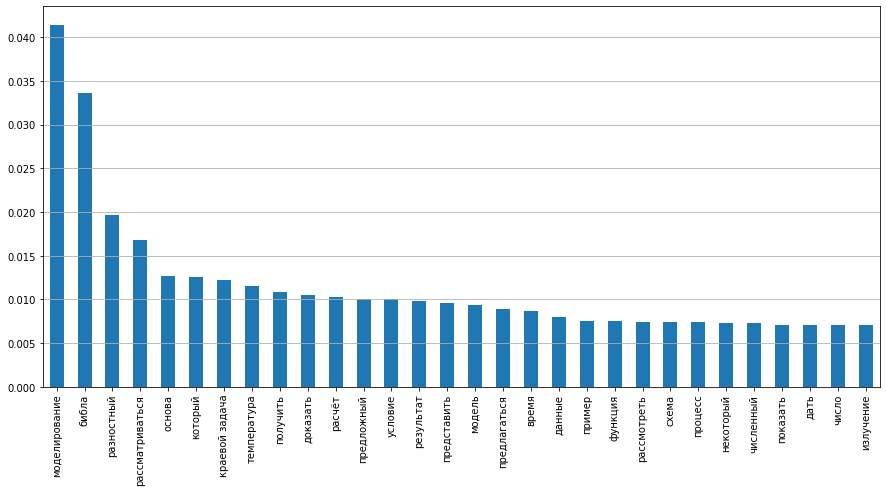

In [121]:
plotCoefficients(rf.feature_importances_.T,vectorizer.get_feature_names_out())

In [122]:
baseline = get_baseline(y_test)
errors={'Baseline':{        
        "Mean absolute error":mean_absolute_error(y_test,baseline),
        "Mean squared error":mean_squared_error(y_test,baseline,squared=True),
        "Root mean squared error":mean_squared_error(y_test,baseline,squared=False)        
        }}
output.append(errors)

In [123]:
y_test.mean()

2005.6859701492538

In [126]:
otputdf = pd.DataFrame.from_dict(output[0], orient= 'index')
for item in output[1:]:
    otputdf = pd.concat([otputdf, pd.DataFrame.from_dict(item, orient= 'index')],axis=0)

# otputdf.columns = ['MAE','MSE','RMSE']

In [127]:
otputdf

,Mean absolute error,Mean squared error,Root mean squared error
Linear Regression,8.712602,119.109721,10.913740
Ridge,8.648850,117.011717,10.817195
Random Forest,8.051480,105.701515,10.281124
Baseline,9.729999,143.196908,11.966491


# Заключение

Были построены модели предсказывающие год публикации по ее аннотации. В наборе данных использовалось 5582 публикаций с годами от 1969 по 2022. 
Baseline модели это усредненный год выпуска публикации среди всех публикаций это 2005.7 и для тестового набора абсолютная погрешность составляет порядка 9.7 лет.
Построенные модели немного лучше предсказывают год в среднем, чем Baseline. Лучше всех стравлялся алгоритм RandomForest для него абсолютная погрешность порядка 8.1 лет.



